# CarND-Vehicle-Detection

## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import glob
import collections
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.ndimage.measurements import label

## Feature Extraction

In [2]:
# Converts colorspace of image from RGB to color_space parameter.
# Always returns a copy of the original image.
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)



# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=5):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Data

### Helper Methods

In [3]:
# Apply brightness conversion to RGB image
def augment_brightness_image(image, adjust=1.25):
    hsv_image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2]*adjust
    adjusted_image = cv2.cvtColor(hsv_image,cv2.COLOR_HSV2RGB)
    return adjusted_image

def get_images_from_files(file_list):
    images = []
    for file in file_list:
        # Read in each one by one
        image = mpimg.imread(file)
        images.append(image)
        brightness_augment_image = augment_brightness_image(image, np.random.uniform(0.75,1.50))
        images.append(brightness_augment_image)
    return images

### Feature Parameters

In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 27  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

### Failed Time-Series Data Extraction

In [5]:
def time_series_split(data, train_fraction=0.9):
    num_data = len(data)
    split_indx = np.int(train_fraction*num_data)
    train = data[:split_indx]
    val = data[split_indx:]
    return train, val
    
def random_split(data, train_fraction):
    rand_state = np.random.randint(0, 100)
    data_train, data_test = train_test_split(data, test_size=0.1, random_state=rand_state)
    return data_train, data_test

def get_train_val_data():
    vehicles_far = glob.glob('vehicles/GTI_Far/*.png')
    vehicles_left = glob.glob('vehicles/GTI_Left/*.png')
    vehicles_middle = glob.glob('vehicles/GTI_MiddleClose/*.png')
    vehicles_right = glob.glob('vehicles/GTI_Right/*.png')
    vehicles_kitti = glob.glob('vehicles/KITTI_extracted/*.png')

    vehicles_time_series = [vehicles_far, vehicles_left, vehicles_middle, vehicles_right]
    vehicle_train_x = []
    vehicle_val_x = []
    for vehicle_data in vehicles_time_series:
        temp_vehicle_train, temp_vehicle_val = time_series_split(vehicle_data, 0.9)
        vehicle_train_x += temp_vehicle_train
        vehicle_val_x += temp_vehicle_val
        
    vehicle_kitti_train, vehicle_kitti_val = random_split(vehicles_kitti, 0.9)
    
    vehicle_train_x += vehicle_kitti_train
    vehicle_val_x += vehicle_kitti_val
    
    non_vehicle_gti = glob.glob('non-vehicles/GTI/*.png')
    non_vehicle_extra = glob.glob('non-vehicles/Extras/*.png')
    
    non_vehicle_train_x = []
    non_vehicle_val_x = []
    
    non_vehicle_gti_train, non_vehicle_gti_val = time_series_split(non_vehicle_gti, 0.9)
    non_vehicle_train_x += non_vehicle_gti_train
    non_vehicle_val_x += non_vehicle_gti_val
    
    non_vehicle_extra_train, non_vehicle_extra_val = random_split(non_vehicle_extra, 0.9)
    non_vehicle_train_x += non_vehicle_extra_train
    non_vehicle_val_x += non_vehicle_extra_val
    
    vehicle_train_images = get_images_from_files(vehicle_train_x)
    vehicle_val_images = get_images_from_files(vehicle_val_x)
    non_vehicle_train_images = get_images_from_files(non_vehicle_train_x)
    non_vehicle_val_images = get_images_from_files(non_vehicle_val_x)
    
    # Extract features for train and val set
    vehicle_train_features = extract_features(vehicle_train_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    vehicle_val_features = extract_features(vehicle_val_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    non_vehicle_train_features = extract_features(non_vehicle_train_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    non_vehicle_val_features = extract_features(non_vehicle_val_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    vehicle_train_y = np.ones(len(vehicle_train_features))
    vehicle_val_y = np.ones(len(vehicle_val_features))
    non_vehicle_train_y = np.zeros(len(non_vehicle_train_features))
    non_vehicle_val_y = np.zeros(len(non_vehicle_val_features))
    
    # Stack train and val sets to scale both
    X = np.vstack((vehicle_train_features, non_vehicle_train_features, 
                   vehicle_val_features, non_vehicle_val_features)).astype(np.float64) 
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    train_size = len(vehicle_train_features) + len(non_vehicle_train_features)
    
    X_train = X[:train_size]
    y_train = np.hstack((vehicle_train_y,non_vehicle_train_y))
    X_val = X[train_size:]
    y_val = np.hstack((vehicle_val_y,non_vehicle_val_y))
    
    return X_train, X_val, y_train, y_val, X_scaler

In [6]:
# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test, X_scaler = get_train_val_data()

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



Using: 27 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 19044
1127.91 Seconds to train SVC...
Test Accuracy of SVC =  0.7846


### Data Extraction & Fit

In [7]:
# Read in cars and notcars
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

# Get image files from filenames
car_images = get_images_from_files(cars)
notcar_images = get_images_from_files(notcars)

# Extract features from images
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


(35520, 19044)
Using: 27 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 19044
243.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9983


### Data Exploration

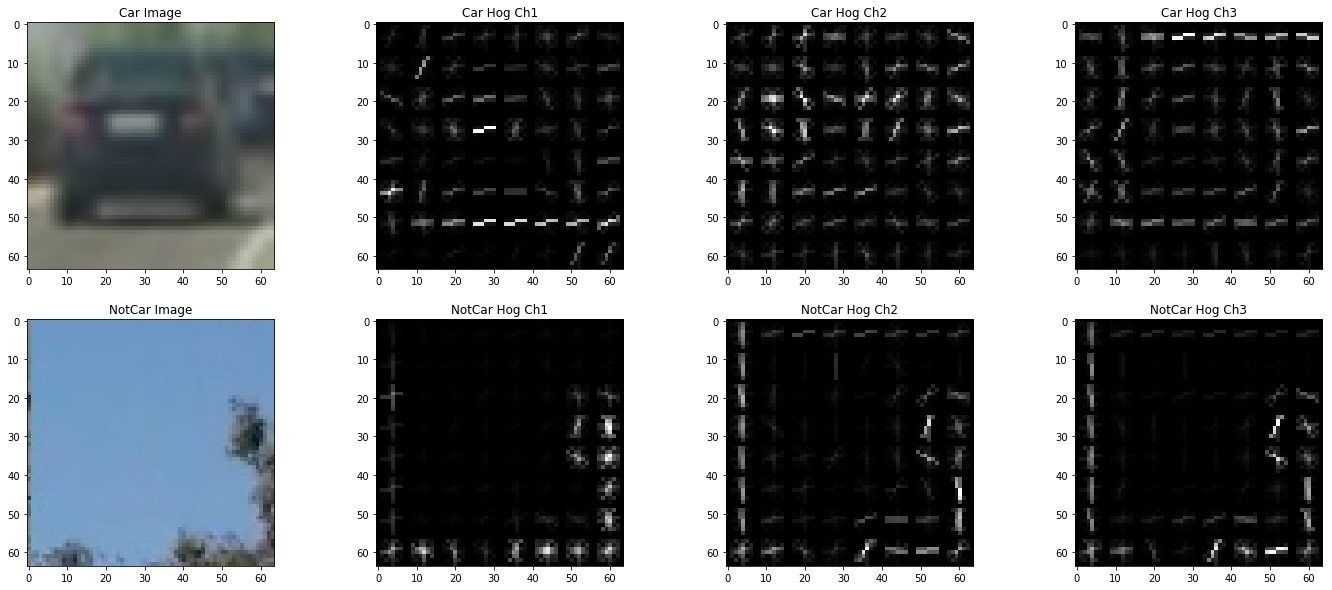

In [8]:
car_image = car_images[0]
notcar_image = notcar_images[0]

ycrcb_car_image = convert_color(car_image, color_space)
ycrcb_notcar_image = convert_color(notcar_image, color_space)

car_ch1_features, car_ch1_hog_img = get_hog_features(ycrcb_car_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
car_ch2_features, car_ch2_hog_img = get_hog_features(ycrcb_car_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
car_ch3_features, car_ch3_hog_img = get_hog_features(ycrcb_car_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


notcar_ch1_features, notcar_ch1_hog_img = get_hog_features(ycrcb_notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
notcar_ch2_features, notcar_ch2_hog_img = get_hog_features(ycrcb_notcar_image[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
notcar_ch3_features, notcar_ch3_hog_img = get_hog_features(ycrcb_notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

f, ((sub0,sub1,sub2,sub3),(sub4,sub5,sub6,sub7)) = plt.subplots(2, 4, figsize=(24, 10))
sub0.imshow(car_image)
sub0.set_title('Car Image')
sub1.imshow(car_ch1_hog_img, cmap='gray')
sub1.set_title('Car Hog Ch1')
sub2.imshow(car_ch2_hog_img, cmap='gray')
sub2.set_title('Car Hog Ch2')
sub3.imshow(car_ch3_hog_img, cmap='gray')
sub3.set_title('Car Hog Ch3')
sub4.imshow(notcar_image)
sub4.set_title('NotCar Image')
sub5.imshow(notcar_ch1_hog_img, cmap='gray')
sub5.set_title('NotCar Hog Ch1')
sub6.imshow(notcar_ch2_hog_img, cmap='gray')
sub6.set_title('NotCar Hog Ch2')
sub7.imshow(notcar_ch3_hog_img, cmap='gray')
sub7.set_title('NotCar Hog Ch3')
plt.show()



## Naive Window Search

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Search hot_windows took 3.94 seconds to run.


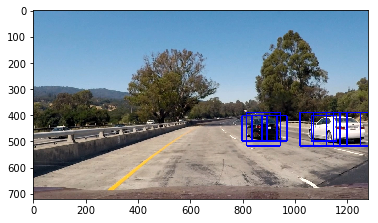

Search hot_windows took 3.91 seconds to run.


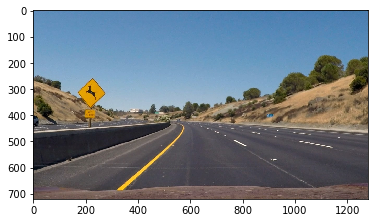

Search hot_windows took 3.95 seconds to run.


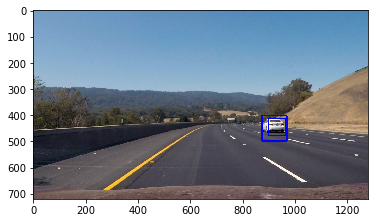

Search hot_windows took 3.8 seconds to run.


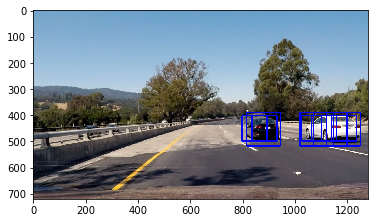

Search hot_windows took 4.56 seconds to run.


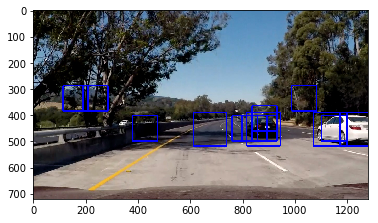

Search hot_windows took 3.59 seconds to run.


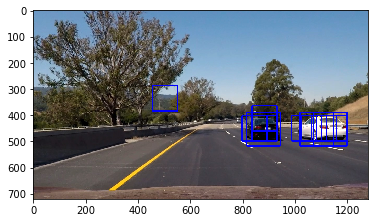

In [10]:
#image = mpimg.imread('test_images/test3.jpg')
#image = mpimg.imread('test_images/crowdai.png')


image_files = glob.glob('test_images/**/*.jpg', recursive=True)

for image_file in image_files:
    image = mpimg.imread(image_file)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)
    
    height = image.shape[0] 
    windows_list = []
    window_size_list = [(128,128), (96,96), (64,64)]
    # Min and max % of height in y to search in slide_window() (corresponds to scale_list)
    y_start_stop_scale_list = [[2/5,4/5],[2/5,3/4],[2/5,2/3]] 
    for i, window_size in enumerate(window_size_list):
        y_start_stop = [np.int(height * y_scale) for y_scale in y_start_stop_scale_list[i]]
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=window_size, xy_overlap=(0.6, 0.6))
        windows_list += windows

    start_hot_time = time.time()
    hot_windows = search_windows(image, windows_list, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    end_hot_time = time.time()
    print("Search hot_windows took {} seconds to run.".format(round(end_hot_time-start_hot_time, 2)))

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)

    plt.imshow(window_img)
    plt.show()

## Hog Subsampling 

In [11]:
# Takes in image and uses HOG subsampling to get HOG for windows of different scale.
# Combines hog subsample with color hist and spatial bin for window to get features.
# Returns heatmap and bboxes drawn on image.
def find_heatmap_and_drawn_images(image, clf, scaler, 
                          y_start=400, y_stop=592, scales=[1], 
                          color_space='RGB', spatial_size=(32, 32),
                          hist_bins=32, orient=9, pix_per_cell=8, 
                          cell_per_block=2, hog_channel=0, 
                          spatial_feat=True, hist_feat=True, hog_feat=True):
    draw_image = np.copy(image)
    heatmap = np.zeros_like(image[:,:,0])
    
    # Crop image to section where we look for cars
    cropped_image = image[y_start:y_stop,:,:]
    # Convert the color to the correct color space
    color_cropped_image = convert_color(cropped_image, color_space)
    start_time = time.time()
    # Iterate through the different scales
    for scale in scales:
        # If the scale isn't 1, resize to height/scale & width/scale
        if scale != 1:
            orig_width = color_cropped_image.shape[1]
            orig_height = color_cropped_image.shape[0]
            scaled_image = cv2.resize(color_cropped_image, (np.int(orig_width/scale), np.int(orig_height/scale)))
        else:
            scaled_image = color_cropped_image

        # Divide scaled image into 3 channels
        ch1 = scaled_image[:,:,0]
        ch2 = scaled_image[:,:,1]
        ch3 = scaled_image[:,:,2]

        width = ch1.shape[1]
        height = ch1.shape[0]

        # Number of blocks in image.
        num_x_blocks = (width // pix_per_cell) + 1 - cell_per_block
        num_y_blocks = (height // pix_per_cell) + 1 - cell_per_block

        # Number of hog features per block
        num_feat_per_block = orient * cell_per_block**2
        window_size = 64
        
        # Number of blocks in window, used for indexing subsample
        num_blocks_per_window = (window_size // pix_per_cell) + 1 - cell_per_block
        
        # Determines overlap in window search
        cells_per_step = 2
        
        # Number of steps that a window will take when sliding in each direction
        num_x_steps = (num_x_blocks - num_blocks_per_window) // cells_per_step
        num_y_steps = (num_y_blocks - num_blocks_per_window) // cells_per_step

        # Get hog features for each channel
        hog1 = hog(ch1, orient, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), feature_vector=False)
        hog2 = hog(ch2, orient, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), feature_vector=False)
        hog3 = hog(ch3, orient, (pix_per_cell,pix_per_cell), (cell_per_block,cell_per_block), feature_vector=False)

        for x_step in range(num_x_steps):
            for y_step in range(num_y_steps):
                # Current starting cell is the step number * number of cells per step
                x_cell_num = x_step * cells_per_step
                y_cell_num = y_step * cells_per_step

                # Extract hog features for the window we're currently interested in
                hog1_win = hog1[y_cell_num:y_cell_num+num_blocks_per_window, x_cell_num:x_cell_num+num_blocks_per_window].ravel()
                hog2_win = hog2[y_cell_num:y_cell_num+num_blocks_per_window, x_cell_num:x_cell_num+num_blocks_per_window].ravel()
                hog3_win = hog3[y_cell_num:y_cell_num+num_blocks_per_window, x_cell_num:x_cell_num+num_blocks_per_window].ravel()
                hog_features = np.hstack((hog1_win, hog2_win, hog3_win))

                # Calculate the top left coordinates of current window
                x_left = x_cell_num*pix_per_cell
                y_top = y_cell_num*pix_per_cell

                # Resize current window section to 64,64 
                # Since window size is already 64 this isn't necessary, but useful if window size changes.
                sub_img = cv2.resize(scaled_image[y_top:y_top+window_size, x_left:x_left+window_size], (64,64))

                # Get spatial and hist features for the sub_img we just calculated
                spatial_features = bin_spatial(sub_img, size=spatial_size)
                hist_features = color_hist(sub_img, nbins=hist_bins)

                # Stack all features in same order as trained, and use SVM to predict
                features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1)
                test_features = scaler.transform(features)
                test_prediction = svc.predict(test_features)

                # If a hit, draw the window onto the copied draw image and add to heatmap
                if test_prediction:
                    window_draw_size = np.int(window_size*scale)
                    x_left_px = np.int(x_left*scale)
                    y_top_px = np.int(y_top*scale + y_start)
                    x_right_px = x_left_px + window_draw_size
                    y_bottom_px = y_top_px + window_draw_size
                    cv2.rectangle(draw_image, (x_left_px, y_top_px), (x_right_px, y_bottom_px), (0,0,1), thickness=5)
                    heatmap[y_top_px:y_bottom_px, x_left_px:x_right_px] += 1
    end_time = time.time()
    #print("Subsampling took {} seconds to search through scales {}.".format(round(end_time-start_time, 2), scales))
    return heatmap, draw_image
                

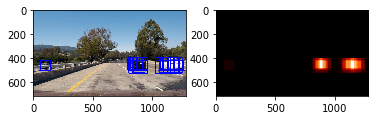

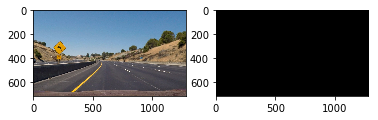

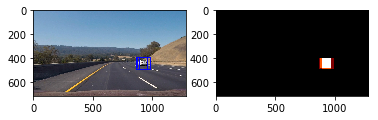

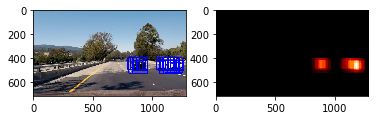

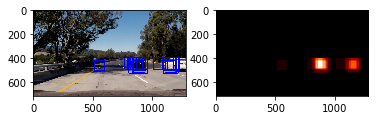

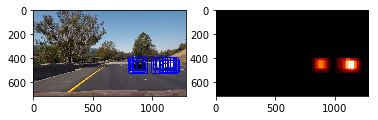

In [12]:
image_files = glob.glob('test_images/**/*.jpg', recursive=True)

for image_file in image_files:
    image = mpimg.imread(image_file)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    heatmap, draw_image = find_heatmap_and_drawn_images(image, svc, X_scaler, 
                          y_start=400, y_stop=592, scales=[4/3,3/2,2], 
                          color_space=color_space, spatial_size=spatial_size,
                          hist_bins=hist_bins, orient=orient, 
                          pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)
    f, (sub1, sub2) = plt.subplots(1, 2)
    sub1.imshow(draw_image)
    sub2.imshow(heatmap, cmap='gist_heat')
    plt.show()

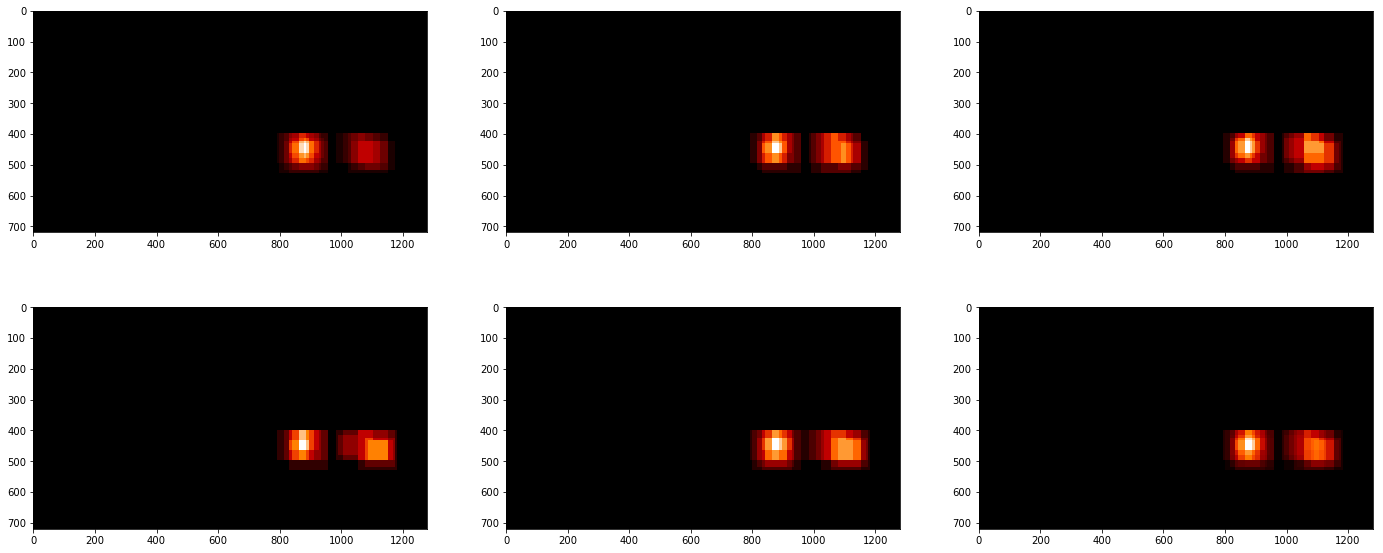

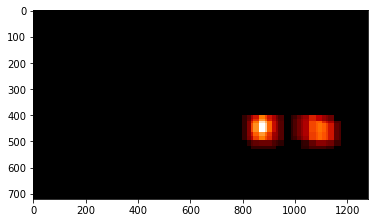

In [13]:
# Stack all heatmaps in list and then take the mean.
def combine_heat_maps(heatmaps):
    combined = np.stack(heatmaps)
    mean_map = np.mean(combined, axis=0)
    return mean_map

# Threshold heatmap so all values below threshold are set to 0.
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
    

test_image_template = "test/test{}.jpg"
images = []
for i in range(950,955):
    image = mpimg.imread(test_image_template.format(i))
    image = image.astype(np.float32)/255
    images.append(image)

heatmaps = []
for img in images:    
    heatmap, _ = find_heatmap_and_drawn_images(img, svc, X_scaler, 
                          y_start=400, y_stop=592, scales=[1,3/2,2], 
                          color_space=color_space, spatial_size=spatial_size,
                          hist_bins=hist_bins, orient=orient, 
                          pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                      hist_feat=hist_feat, hog_feat=hog_feat)
    heatmaps.append(heatmap)

combined_heatmap = combine_heat_maps(heatmaps)
f, ((sub0,sub1,sub2),(sub3,sub4,sub5)) = plt.subplots(2, 3, figsize=(24, 10))
sub0.imshow(heatmaps[0], cmap='gist_heat')
sub1.imshow(heatmaps[1], cmap='gist_heat')
sub2.imshow(heatmaps[2], cmap='gist_heat')
sub3.imshow(heatmaps[3], cmap='gist_heat')
sub4.imshow(heatmaps[4], cmap='gist_heat')
sub5.imshow(combined_heatmap, cmap='gist_heat')
plt.show()

threshold_heatmap = apply_threshold(combined_heatmap, 1)
plt.imshow(threshold_heatmap, cmap='gist_heat')
plt.show()

In [14]:
def draw_labeled_boxes(img, combined_heatmap):
    labels = label(combined_heatmap)
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return draw_boxes(img, bboxes, color=(0,0,1))

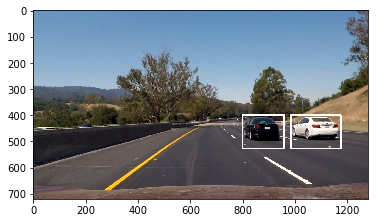

In [15]:
labeled_image = draw_labeled_boxes(image, threshold_heatmap)
plt.imshow(labeled_image)
plt.show()

In [16]:
queue_len = 6
heatmap_queue = collections.deque(maxlen=queue_len)

def pipeline(frame):
    #plt.imsave("test/test{}.jpg".format(pipeline.counter), frame)
    frame = frame.astype(np.float32)/255
    heatmap, _ = find_heatmap_and_drawn_images(frame, svc, X_scaler, 
                                               y_start=400, y_stop=592, scales=[1,3/2,2], 
                                               color_space=color_space, spatial_size=spatial_size,
                                               hist_bins=hist_bins, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                               hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                               hist_feat=hist_feat, hog_feat=hog_feat)
    #plt.imsave("heat/heat{}.jpg".format(pipeline.counter), heatmap)
    heatmap_queue.append(heatmap)
    if len(heatmap_queue) == queue_len:
        combined_heatmap = combine_heat_maps(heatmap_queue)
        threshold_heatmap = apply_threshold(combined_heatmap, 0.75)
        #plt.imsave("heat_thresh/heat_thresh{}.jpg".format(pipeline.counter), threshold_heatmap)
        labeled_frame = draw_labeled_boxes(frame, threshold_heatmap)
    else:
        labeled_frame = frame    
    labeled_frame = labeled_frame.astype(np.float32)*255
    #plt.imsave("labeled/labeled{}.jpg".format(pipeline.counter), labeled_frame.astype(np.uint8))
    pipeline.counter += 1
    return labeled_frame 

pipeline.counter = 0

In [17]:
from moviepy.editor import VideoFileClip

video_output_filename = 'project_video_labeled.mp4'
clip1 = VideoFileClip("project_video_original.mp4")
#video_output_filename = 'test_video_labeled.mp4'
#clip1 = VideoFileClip("test_video.mp4")
video_clip = clip1.fl_image(pipeline)
video_clip.write_videofile(video_output_filename, audio=False)

[MoviePy] >>>> Building video project_video_labeled.mp4
[MoviePy] Writing video project_video_labeled.mp4


100%|█████████▉| 1260/1261 [24:46<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_labeled.mp4 

